### TITLE

<>:9: SyntaxWarning: invalid escape sequence '\m'
<>:9: SyntaxWarning: invalid escape sequence '\m'
C:\Users\lilit\AppData\Local\Temp\ipykernel_19000\692521823.py:9: SyntaxWarning: invalid escape sequence '\m'
  plt.ylabel('$\mu$')


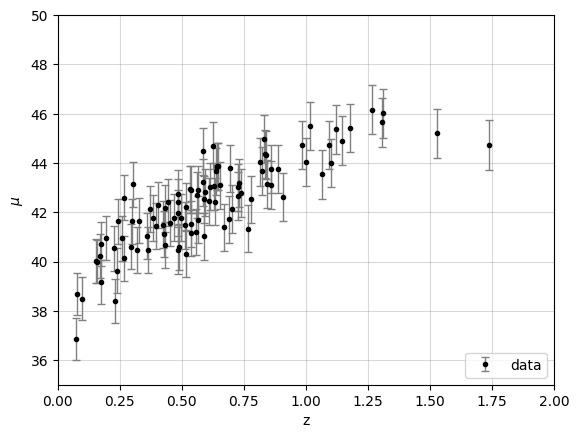

In [2]:
from astroML.datasets import generate_mu_z
import matplotlib.pyplot as plt

N = 100     # Number of samples to generate
z_sample, mu_sample, dmu = generate_mu_z(N, random_state=1234)

plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', capsize=3, lw=1,label='data')
plt.xlabel('z')
plt.ylabel('$\mu$')
plt.legend(loc='lower right')
plt.grid(alpha=0.3, c='gray')
plt.xlim(0,2)
plt.ylim(35,50)
plt.show()

C:\Users\lilit\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 0.1. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


[38.9032104  39.49727994 39.88488834 40.06675792 40.09051722 40.04497422
 40.03330558 40.13613302 40.38098059 40.73248327 41.10859471 41.41611146
 41.58984236 41.61811919 41.54387257 41.44195841 41.3842154  41.40874551
 41.5070186  41.63339357 41.73110863 41.76171988 41.72435288 41.65673349
 41.61870661 41.6666143  41.83014863 42.10109383 42.43726158 42.77808148
 43.063968   43.25150373 43.32017143 43.2714448  43.1245364  42.91309311
 42.68391593 42.49474691 42.40641644 42.46703015 42.69159281 43.04618431
 43.44744483 43.78340531 43.95189879 43.9025744  43.66367771 43.33889235
 43.07179954 42.99052668 43.15554168 43.533716   44.0109878  44.4389335
 44.69527846 44.73212814 44.59145196 44.38231513 44.23141081 44.22968068
 44.39831024 44.68743489 45.00558268 45.26444246 45.41787355 45.47811521
 45.50336779 45.5638177  45.70206914 45.90543454 46.1017254  46.18018334
 46.02940567 45.57827102 44.82562653 43.849188   42.7914107  41.82722077
 41.12327395 40.7998386  40.90469545 41.40462724 42.

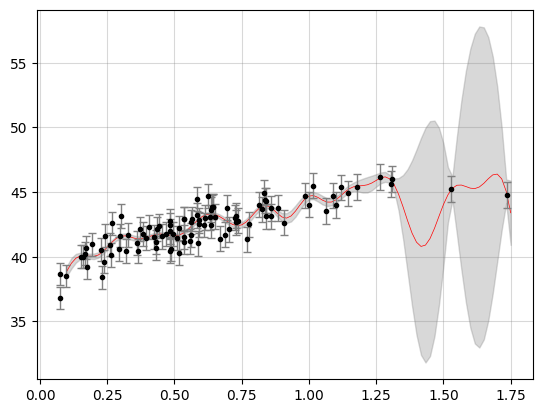

In [27]:
from sklearn.gaussian_process import GaussianProcessRegressor, kernels
import numpy as np

kernel3 = kernels.RBF(5, (0.1, 1.75))
gp3 = GaussianProcessRegressor(kernel=kernel3, alpha=(dmu / mu_sample) ** 2, random_state=0)

x = np.linspace(0.1, 1.75, 100)

gp3.fit(z_sample[:, None], mu_sample[:, None])
f3, f3_err = gp3.predict(x[:, None], return_std=True)
print(f3)

plt.plot(x, f3, ls = '-', color = 'red', lw = 0.5)
plt.fill_between(x, f3 - 20 * f3_err, f3 + 20 * f3_err, color='gray', alpha=0.3)
plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', capsize=3, lw=1, ms=6)
plt.grid(c='grey', alpha = 0.3)

plt.show()